In [129]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

In [130]:
df = pd.read_csv('data.csv', index_col="date",parse_dates=["date"])
df.head()

,open,high,low,close,adjusted_close,volume,SMA_20,EMA_21,SMA_20_gt_EMA21,RSI_14,OBV,ROC_1,ROC_BOOL
date,,,,,,,,,,,,,
1999-11-01,19.94,20.44,19.88,20.31,10.155,1563700.0,0.0,0.0,0,0.0,3127400.0,0.0000,0
1999-11-02,20.31,20.81,20.31,20.56,10.280,1898100.0,0.0,0.0,0,0.0,6923600.0,1.2309,1
1999-11-03,20.69,21.50,20.56,21.31,10.655,2236000.0,0.0,0.0,0,0.0,11395600.0,3.6479,1
1999-11-04,21.13,21.31,19.94,20.63,10.315,2415000.0,0.0,0.0,0,0.0,6565600.0,-3.1910,0
1999-11-05,20.75,21.38,20.25,21.25,10.625,2148000.0,0.0,0.0,0,0.0,10861600.0,3.0053,1


In [131]:
df.insert(5, 'shifted_ROC_BOOL', df['ROC_BOOL'].shift(-1))

In [132]:
df.dropna(inplace=True)
df.head()

,open,high,low,close,adjusted_close,shifted_ROC_BOOL,volume,SMA_20,EMA_21,SMA_20_gt_EMA21,RSI_14,OBV,ROC_1,ROC_BOOL
date,,,,,,,,,,,,,,
1999-11-01,19.94,20.44,19.88,20.31,10.155,1.0,1563700.0,0.0,0.0,0,0.0,3127400.0,0.0000,0
1999-11-02,20.31,20.81,20.31,20.56,10.280,1.0,1898100.0,0.0,0.0,0,0.0,6923600.0,1.2309,1
1999-11-03,20.69,21.50,20.56,21.31,10.655,0.0,2236000.0,0.0,0.0,0,0.0,11395600.0,3.6479,1
1999-11-04,21.13,21.31,19.94,20.63,10.315,1.0,2415000.0,0.0,0.0,0,0.0,6565600.0,-3.1910,0
1999-11-05,20.75,21.38,20.25,21.25,10.625,1.0,2148000.0,0.0,0.0,0,0.0,10861600.0,3.0053,1


In [133]:
df.sort_index(axis=0,ascending=True,inplace=True)

In [134]:
x = df.drop(['open', 'adjusted_close', 'high', 'low', 'shifted_ROC_BOOL','SMA_20_gt_EMA21', 'ROC_BOOL','ROC_1'], axis=1).copy()
x.head()

,close,volume,SMA_20,EMA_21,RSI_14,OBV
date,,,,,,
1999-11-01,20.31,1563700.0,0.0,0.0,0.0,3127400.0
1999-11-02,20.56,1898100.0,0.0,0.0,0.0,6923600.0
1999-11-03,21.31,2236000.0,0.0,0.0,0.0,11395600.0
1999-11-04,20.63,2415000.0,0.0,0.0,0.0,6565600.0
1999-11-05,21.25,2148000.0,0.0,0.0,0.0,10861600.0


In [135]:
y = df['shifted_ROC_BOOL'].copy()
y.head()

date
1999-11-01    1.0
1999-11-02    1.0
1999-11-03    0.0
1999-11-04    1.0
1999-11-05    1.0
Name: shifted_ROC_BOOL, dtype: float64

In [136]:
train_x,test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [137]:
train = xgb.DMatrix(train_x, label=train_y)
test = xgb.DMatrix(test_x, label=test_y)
param = {
    'max_depth': 18,
    'eta' : 0.2,
    'objective': 'binary:hinge'
}
epochs=20

In [138]:
model = xgb.train(param,train,epochs)

In [139]:
predictions_in_sample = model.predict(train)
predictions = model.predict(test)

In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_out = accuracy_score(test_y, predictions)
accuracy_in = accuracy_score(train_y, predictions_in_sample)

precision_out = precision_score(test_y, predictions)
precision_in = precision_score(train_y, predictions_in_sample)

recall_out = recall_score(test_y, predictions)
recall_in = recall_score(train_y, predictions_in_sample)

f_score_out = f1_score(test_y, predictions)
f_score_in = f1_score(train_y, predictions_in_sample)


print(f"Accuracy out-of-sample: {accuracy_out}")
print(f"Precision out-of-sample: {precision_out}")
print(f"Recall out-of-sample: {recall_out}")
print(f"FScore out-of-sample: {f_score_out}\n")

print(f"Accuracy in-sample: {accuracy_in}" )
print(f"Precision in-sample: {precision_in}" )
print(f"Recall in-sample: {recall_in}" )
print(f"FScore in-sample: {f_score_in}")


Accuracy out-of-sample: 0.5009225092250923
Precision out-of-sample: 0.5864661654135338
Recall out-of-sample: 0.13829787234042554
FScore out-of-sample: 0.2238163558106169

Accuracy in-sample: 0.9903091832025842
Precision in-sample: 0.9833564493758669
Recall in-sample: 0.9971870604781997
FScore in-sample: 0.9902234636871509


In [141]:
confusion_matrix(test_y, predictions)/len(test_y)*100

array([[42.89667897,  5.07380074],
       [44.83394834,  7.19557196]])

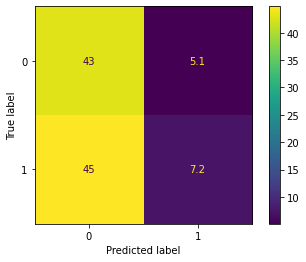

In [142]:
cm_out = confusion_matrix(test_y, predictions)/len(test_y)*100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_out)
disp.plot() 

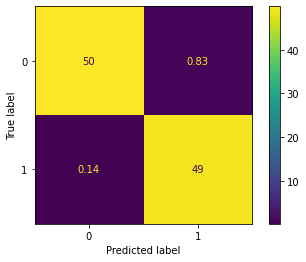

In [143]:
cm_in = confusion_matrix(train_y, predictions_in_sample)/len(train_y)*100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_in)
disp.plot()

In [144]:
# xgb.plot_tree(model, num_trees=0)
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()